# FiftyOne Finetune DinoV2 with HuggingFace Transformers for ChestXray Dataset

In this tutorial, we will:

* Examine the ChestXray dataset using FiftyOne,
* Finetune a Dinov2 model from HuggingFace Transformers on the ChestXray dataset, which has 2 classes,
* Evaluate the finetuned model on the validation subset,
* Compare predictions and ground truths using FiftyOne.

Let's start by installing the required libraries.

## Setup

Firstly, install HuggingFace datasets, transformers and FiftyOne.

In [1]:
# !pip install datasets transformers --upgrade

In [2]:
# !pip install fiftyone 

## Dataset

Now, let's download the dataset.

In [3]:
import os
import tqdm
import fiftyone as fo

from datasets import load_dataset

dataset_root = "./datasets"
dataset_splits = ["train", "validation", "test"]

dataset_name = "trpakov/chest-xray-classification"

dataset = load_dataset(dataset_name, name="full")

class_names = dataset["train"].features["labels"].names
labels = class_names

id2label = {id: str(label) for id, label in enumerate(labels)}
label2id = {str(label): id for id, label in enumerate(labels)}

print(f"id2label: {id2label}")

for dataset_split in dataset_splits:
    dataset_save_folder = os.path.join(dataset_root, dataset_split)
    if not os.path.exists(dataset_save_folder):
        os.makedirs(dataset_save_folder)
        
        for image_idx, image_cl_dict in tqdm.tqdm(enumerate(dataset[dataset_split]),
                                                  total=len(dataset[dataset_split]),
                                                  desc=f"Saving {dataset_split} images"):
            image = image_cl_dict["image"]
            cls = id2label[int(image_cl_dict["labels"])]
            
            cls_folder = os.path.join(dataset_save_folder, cls)
            if not os.path.exists(cls_folder):
                os.makedirs(cls_folder)
                
            image.save(f"{cls_folder}/image_{image_idx}.jpg")

print(dataset)

id2label: {0: 'PNEUMONIA', 1: 'NORMAL'}
DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 12230
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})


Now, visualize the first sample of ChestXray dataset.

label: 1


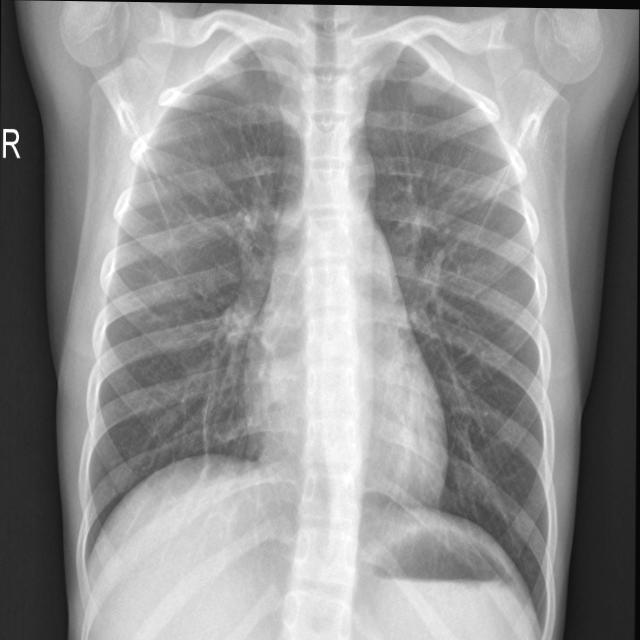

In [4]:
example = dataset["train"][0]

print(f"label: {example['labels']}")
example["image"]

FiftyOne is an open-source toolkit for visualizing and curating datasets. In this stage, we will visualize all samples from the ChestXray dataset on the FiftyOne web UI.

In [5]:
try:
    fo.delete_dataset(dataset_name)
except:
    pass
fiftyone_dataset = fo.Dataset(dataset_name)

dataset_type = fo.types.ImageClassificationDirectoryTree

for dataset_split in dataset_splits:
    dataset_dir = os.path.join(dataset_root, dataset_split)
    fiftyone_dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        tags=dataset_split,
    )

 100% |█████████████| 12230/12230 [3.8s elapsed, 0s remaining, 3.4K samples/s]      
 100% |███████████████| 1165/1165 [335.1ms elapsed, 0s remaining, 3.5K samples/s]      
 100% |█████████████████| 582/582 [179.4ms elapsed, 0s remaining, 3.2K samples/s]     



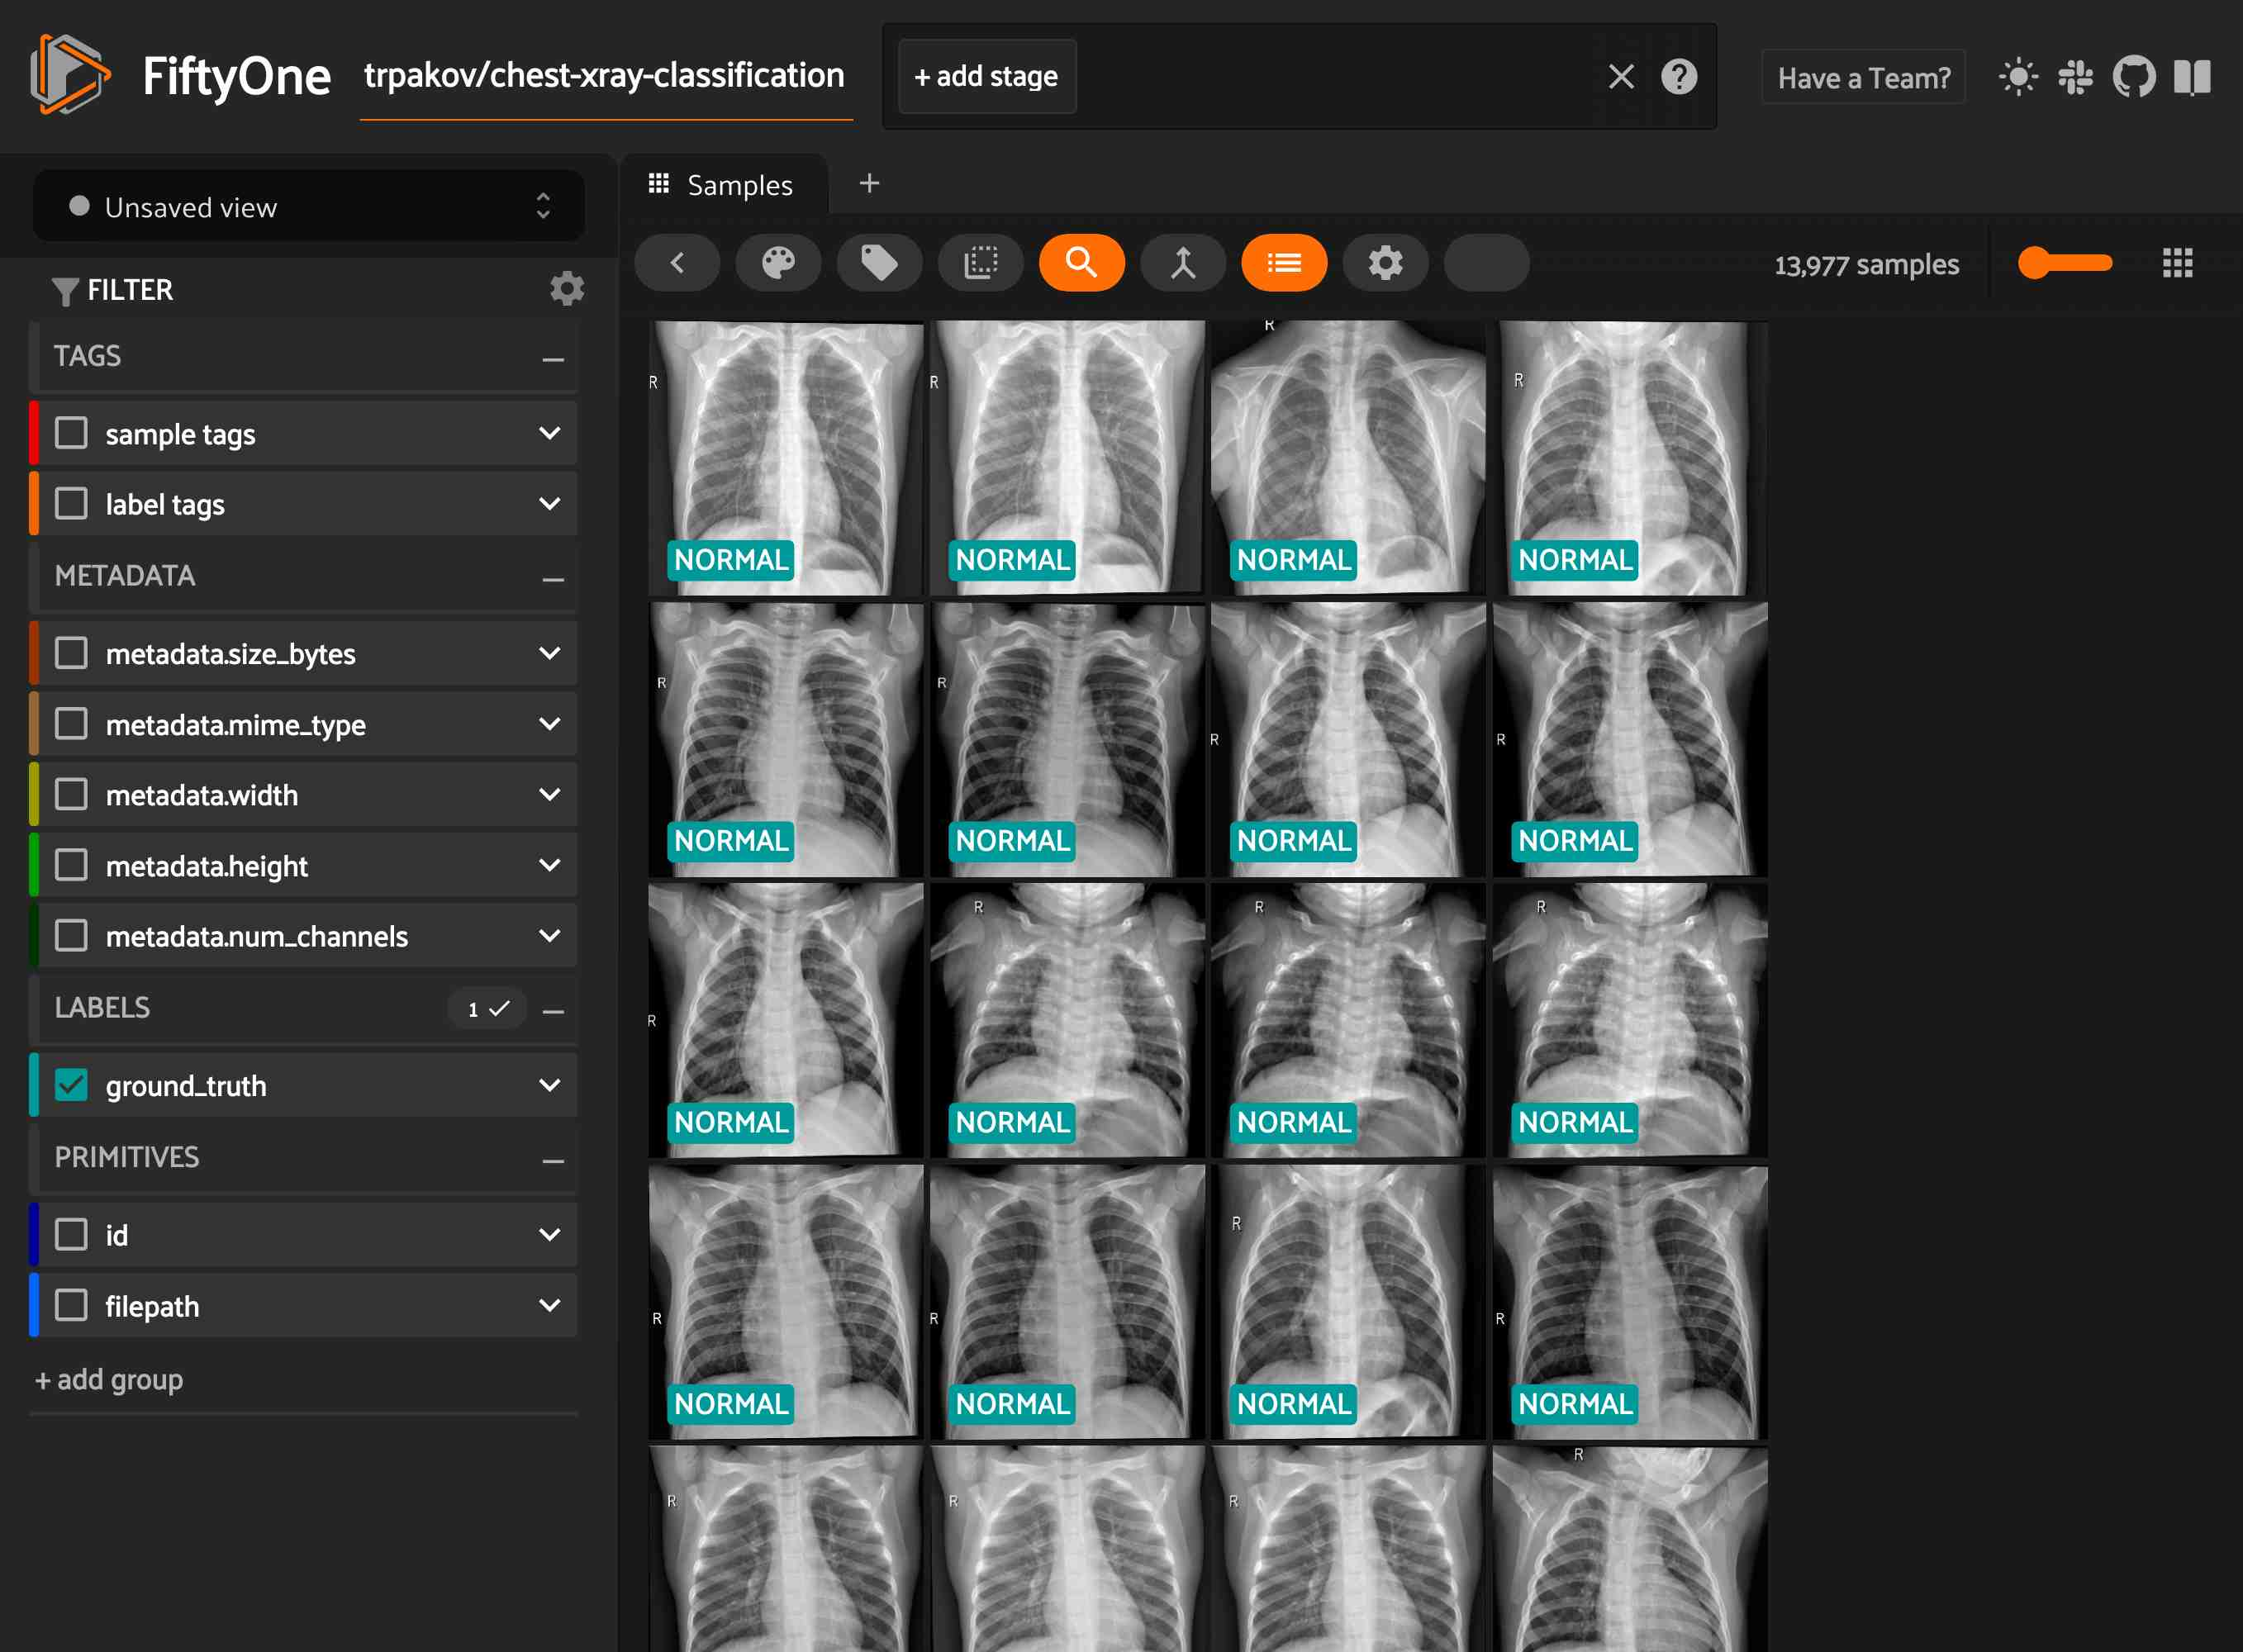

In [6]:
session = fo.launch_app(fiftyone_dataset)

Now, we will define and load the preprocessor and the model. Here, we will utilize the Dinov2-base model from Meta.

In [7]:
import torch

from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset

model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)

print(processor)

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}



In [8]:
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

To obtain a robust model, we will apply some augmentations to the training dataset. 

In [9]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize
import torch

# Extarct image mean, std and interpolation from the inference processor
mean = processor.image_mean
std = processor.image_std
interpolation = processor.resample

train_transform = Compose([
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=interpolation),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

In [10]:
def prepare_data(batch, mode="train"):
  images = batch["image"]

  if mode == "train":
    images = [train_transform(image.convert("RGB")) for image in images]
    pixel_values = torch.stack(images)
  elif mode == "test":
    pixel_values = processor(images, return_tensors="pt").pixel_values
  else:
    raise ValueError(f"Mode {mode} not supported")

  inputs = {}
  inputs["pixel_values"] = pixel_values
  inputs["labels"] = torch.tensor(batch["labels"])

  return inputs

# set num_proc equal to the number of CPU cores on your machine
train_dataset = dataset["train"].map(prepare_data, num_proc=1, batched=True, batch_size=20, fn_kwargs={"mode":"train"})
eval_dataset = dataset["test"].map(prepare_data, num_proc=1, batched=True, batch_size=20, fn_kwargs={"mode":"test"})

Make the dataset suitable for Pytorch.

In [11]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

Here, collate_fn is used for batching examples.

In [12]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Training the Model

In this stage, we will define training arguments and evaluation metrics.

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"{model_name}",
    per_device_train_batch_size=32,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_score(y_pred=predictions, y_true=eval_pred.label_ids)
    return {"accuracy": accuracy}

In [15]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

Now, we are ready to start finetuning our model.

In [16]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.477300,0.441990,0.817869
200,0.475500,0.403701,0.828179
300,0.470000,0.427249,0.828179
400,0.497800,0.543817,0.745704
500,0.452300,0.434548,0.798969
600,0.466100,0.454770,0.737113
700,0.460100,0.390835,0.809278
800,0.444800,nan,0.718213
900,0.040000,nan,0.695876
1000,0.029400,nan,0.706186


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 3562792493GF
  train_loss               =       0.2489
  train_runtime            =   0:22:04.82
  train_samples_per_second =       36.926
  train_steps_per_second   =        1.156


## Evaluate the Finetuned Model

After training, evaluate the finetuned model.

In [17]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8282
  eval_loss               =     0.4037
  eval_runtime            = 0:00:09.98
  eval_samples_per_second =     58.267
  eval_steps_per_second   =      7.308


In [18]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

finetuned_model_folder = "./facebook/dinov2-base"

image_processor = AutoImageProcessor.from_pretrained(finetuned_model_folder)
model = AutoModelForImageClassification.from_pretrained(finetuned_model_folder)

In [19]:
from PIL import Image
import torch

def infer(image):
    # prepare image for the model
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    
    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predicted_class = id2label[predicted_class_idx]
        return predicted_class

In [20]:
fiftyone_test_dataset = fiftyone_dataset.match_tags("test")
for sample in fiftyone_test_dataset.iter_samples(autosave=True, progress=True):
    image_path = sample.filepath
    image = Image.open(image_path)
    predicted_class = infer(image)
    sample["dinov2_prediction"] = fo.Classification(label=predicted_class)

 100% |█████████████████| 582/582 [1.3m elapsed, 0s remaining, 7.3 samples/s]      


In [21]:
session.view = fiftyone_test_dataset

In [22]:
results = fiftyone_test_dataset.evaluate_classifications(
    "dinov2_prediction",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=labels,
)

In [23]:
results.print_report()

              precision    recall  f1-score   support

   PNEUMONIA       0.85      0.92      0.88       411
      NORMAL       0.76      0.61      0.68       171

    accuracy                           0.83       582
   macro avg       0.80      0.77      0.78       582
weighted avg       0.82      0.83      0.82       582



In [24]:
plot = results.plot_confusion_matrix()
plot.show()

FigureWidget({
    'data': [{'mode': 'markers',
              'opacity': 0.1,
              'type': 'scatter',
              'uid': '1b9e78f8-239a-4990-a136-3940c81992b0',
              'x': array([0, 1, 0, 1]),
              'y': array([0, 0, 1, 1])},
             {'colorscale': [[0.0, 'rgb(255,245,235)'], [0.125,
                             'rgb(254,230,206)'], [0.25, 'rgb(253,208,162)'],
                             [0.375, 'rgb(253,174,107)'], [0.5, 'rgb(253,141,60)'],
                             [0.625, 'rgb(241,105,19)'], [0.75, 'rgb(217,72,1)'],
                             [0.875, 'rgb(166,54,3)'], [1.0, 'rgb(127,39,4)']],
              'hoverinfo': 'skip',
              'showscale': False,
              'type': 'heatmap',
              'uid': '9e4d7129-836f-4c57-bbff-860e1b505ed5',
              'z': array([[ 66, 105],
                          [377,  34]]),
              'zmax': 377,
              'zmin': 0},
             {'colorbar': {'len': 1, 'lenmode': 'fraction'},
    

In [25]:
plot = results.plot_pr_curve()
plot.show()

FigureWidget({
    'data': [{'customdata': array([0., 1., 1.]),
              'fill': 'tozeroy',
              'hovertemplate': ('recall: %{x:.3f}<br>precision:' ... 'customdata:.3f}<extra></extra>'),
              'line': {'color': '#FF6D04'},
              'mode': 'lines',
              'type': 'scatter',
              'uid': 'ad9b7308-2fef-4a70-82e2-393fb674acc5',
              'x': array([1.        , 0.38596491, 0.        ]),
              'y': array([0.29381443, 0.1489842 , 1.        ])}],
    'layout': {'margin': {'b': 0, 'l': 0, 'r': 0, 't': 30},
               'shapes': [{'line': {'dash': 'dash'}, 'type': 'line', 'x0': 0, 'x1': 1, 'y0': 1, 'y1': 0}],
               'template': '...',
               'title': {'text': 'AP = 0.24'},
               'xaxis': {'constrain': 'domain', 'range': [0, 1], 'title': {'text': 'Recall'}},
               'yaxis': {'constrain': 'domain',
                         'range': [0, 1],
                         'scaleanchor': 'x',
                      

In [26]:
print(fiftyone_test_dataset.count_values("eval"))

{'TP': 105, 'TN': 377, 'FP': 34, 'FN': 66}


In [27]:
from fiftyone import ViewField as F

session.view = (
    fiftyone_test_dataset
    .match(F("dinov2_prediction.label") != F("ground_truth.label"))
)

In [28]:
session.freeze()